In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data=pd.read_csv(r"C:\Users\HP\Desktop\MLProject\data\train.csv")

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data=np.array(data)

In [5]:
m,n=data.shape

In [6]:
np.random.shuffle(data)

In [7]:
data_test=data[0:1000].T

In [8]:
y_test=data_test[0]
x_test=data_test[1:n]
x_test=x_test/255

In [9]:
data_train=data[1000:m].T

In [10]:
y_train=data_train[0]
x_train=data_train[1:n]
x_train=x_train/255

In [11]:
train_losses = []
val_losses = []

In [15]:
def ReLU(z):
    return np.maximum(z,0)
    
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z,axis=0, keepdims=True)

def init_params():
    w1=np.random.randn(128,784)*np.sqrt(2/784)
    b1=np.zeros((128,1))
    w2=np.random.randn(64,128)*np.sqrt(2/128)
    b2=np.zeros((64,1))
    w3=np.random.randn(10,64)*np.sqrt(2/64)
    b3=np.zeros((10,1))
    return w1,b1,w2,b2,w3,b3

def forward_prop(w1,b1,w2,b2,w3,b3,x):
    z1=w1.dot(x) + b1
    a1=ReLU(z1)
    z2=w2.dot(a1) + b2
    a2=ReLU(z2)
    z3=w3.dot(a2) + b3
    a3=softmax(z3)
    return z1,a1,z2,a2,z3,a3

def one_hot(y):
    one_hot_y=np.zeros((y.size,y.max()+1))
    one_hot_y[np.arange(y.size),y]=1
    one_hot_y=one_hot_y.T
    return one_hot_y

def derv_ReLU(z):
    return z>0

def back_prop(z1,a1,z2,a2,z3,a3,w2,w3,x,y):
    m=y.size
    one_y=one_hot(y)
    dz3=a3-one_y
    dw3=1/m*dz3.dot(a2.T)
    db3=1/m*np.sum(dz3, axis=1, keepdims=True)
    dz2=w3.T.dot(dz3)*derv_ReLU(z2)
    dw2=1/m*dz2.dot(a1.T)
    db2=1/m*np.sum(dz2, axis=1, keepdims=True)
    dz1=w2.T.dot(dz2)*derv_ReLU(z1)
    dw1=1/m*dz1.dot(x.T)
    db1=1/m*np.sum(dz1, axis=1, keepdims=True)
    return dw1,db1,dw2,db2,dw3,db3

def init_adam(w1,b1,w2,b2,w3,b3):
    v={k: np.zeros_like(v) for k,v in {"w1":w1,"b1":b1,"w2":w2,"b2":b2,"w3":w3,"b3":b3}.items()}
    s={k: np.zeros_like(v) for k,v in {"w1":w1,"b1":b1,"w2":w2,"b2":b2,"w3":w3,"b3":b3}.items()}
    return v,s

def update_params_adam(w1,b1,w2,b2,w3,b3,dw1,db1,dw2,db2,dw3,db3,v,s,i,alpha=0.001,beta1=0.9,beta2=0.999,eps=1e-8):
    grads={"w1":dw1,"b1":db1,"w2":dw2,"b2":db2,"w3":dw3,"b3":db3}
    params={"w1":w1,"b1":b1,"w2":w2,"b2":b2,"w3":w3,"b3":b3}
    for key in params.keys():
        v[key]=beta1*v[key]+(1-beta1)*grads[key]
        s[key]=beta2*s[key]+(1-beta2)*(grads[key]**2)
        v_corr=v[key]/(1-beta1**i)
        s_corr=s[key]/(1-beta2**i)
        params[key]-=alpha*v_corr/(np.sqrt(s_corr)+eps)
        return params["w1"],params["b1"],params["w2"],params["b2"],params["w3"],params["b3"],v,s

def compute_loss(a2, y):
    m = y.size
    oh_Y = one_hot(y)
    # cross-entropy
    loss = -1/m * np.sum(oh_Y * np.log(a2 + 1e-8))  # add epsilon to avoid log(0)
    return loss

def get_predictions(a3):
    return np.argmax(a3,0)

def get_accuracy(predictions,y):
    print(predictions,y)
    return np.sum(predictions==y)/y.size

def gradient_descent(x,y,iterations=1000,alpha=0.001):
    w1,b1,w2,b2,w3,b3=init_params()
    v,s=init_adam(w1,b1,w2,b2,w3,b3)
    for i in range(1,iterations+1):
        z1,a1,z2,a2,z3,a3=forward_prop(w1,b1,w2,b2,w3,b3,x)
        dw1,db1,dw2,db2,dw3,db3=back_prop(z1,a1,z2,a2,z3,a3,w2,w3,x,y)
        w1,b1,w2,b2,w3,b3,v,s=update_params_adam(w1,b1,w2,b2,w3,b3,dw1,db1,dw2,db2,dw3,db3,v,s,i,alpha)
        if(i%50==0):
            print("Iteration:",i)
            print("Accuracy:",get_accuracy(get_predictions(a3),y),"Loss:",compute_loss(a3,y))
    return w1,b1,w2,b2,w3,b3


In [16]:
w1,b1,w2,b2,w3,b3=gradient_descent(x_train,y_train,1000,0.001)

Iteration: 50
[7 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.8971463414634147 Loss: 0.4028851096903047
Iteration: 100
[7 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.930829268292683 Loss: 0.2665479971156706
Iteration: 150
[7 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.9445365853658536 Loss: 0.21481460541372416
Iteration: 200
[7 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.9527317073170731 Loss: 0.18360187671673983
Iteration: 250
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.9584390243902439 Loss: 0.16145917018200787
Iteration: 300
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.9627073170731707 Loss: 0.1445637615822299
Iteration: 350
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.9667560975609756 Loss: 0.13101795507918476
Iteration: 400
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.9698536585365853 Loss: 0.11976891750814851
Iteration: 450
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
Accuracy: 0.9722195121951219 Loss: 0.11022414299973562
Iteration: 500
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]


In [17]:
def make_prediction(x,w1,b1,w2,b2,w3,b3):
    _, _, _, _, _, a3=forward_prop(w1,b1,w2,b2,w3,b3,x)
    predictions=get_predictions(a3)
    return predictions

def test_prediction(index,w1,b1,w2,b2,w3,b3):
    current_image=x_test[:,index,None]
    prediction=make_prediction(x_test[:,index,None],w1,b1,w2,b2,w3,b3)
    label=y_test[index]
    print("Prediction:",prediction)
    print("Label",label)
    current_image=current_image.reshape(28,28)*255
    plt.gray()
    plt.imshow(current_image,interpolation='nearest')
    plt.show()

Prediction: [6]
Label 6


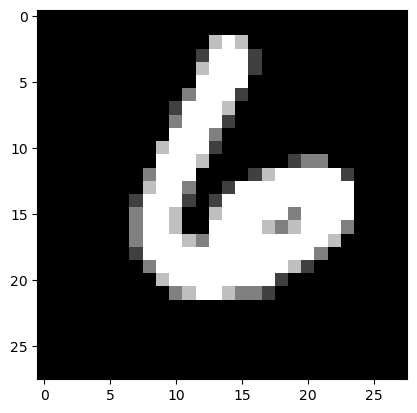

In [20]:
test_prediction(5,w1,b1,w2,b2,w3,b3)

In [21]:
test_preds=make_prediction(x_test,w1,b1,w2,b2,w3,b3)
get_accuracy(test_preds,y_test)

[2 4 1 2 3 6 8 3 2 2 3 1 1 4 5 5 6 8 5 4 4 2 2 6 5 3 7 5 2 1 0 8 1 1 9 9 8
 1 7 1 5 9 4 7 0 9 5 9 1 1 2 6 7 8 9 5 9 3 4 0 9 0 0 3 5 1 6 3 6 1 5 0 5 0
 6 9 7 9 9 6 0 4 7 6 3 7 0 5 9 1 5 2 5 5 9 1 3 4 7 0 3 6 6 3 9 7 6 1 3 9 0
 6 5 3 2 7 1 4 5 4 8 4 6 1 8 4 7 2 4 4 6 4 1 1 7 1 2 0 7 6 2 6 6 9 6 7 9 1
 4 1 0 7 1 5 4 9 6 5 7 3 3 0 6 0 5 1 6 1 2 7 2 8 0 0 9 5 3 1 4 1 8 5 4 6 9
 4 2 6 7 4 8 8 5 0 9 2 1 9 7 5 9 4 3 4 7 9 6 8 2 2 4 0 4 4 4 2 8 7 4 8 0 8
 4 3 1 4 9 9 2 5 8 1 8 1 0 3 3 4 8 3 6 3 2 6 6 8 1 0 6 7 5 8 2 0 3 1 0 8 7
 3 7 4 6 7 2 7 6 2 3 7 4 1 8 0 7 8 7 6 0 3 8 0 6 9 5 2 6 6 0 0 3 6 1 0 9 1
 2 1 6 5 9 9 4 4 7 2 4 6 9 6 0 9 6 5 6 5 9 1 9 7 6 8 6 1 1 1 8 2 1 1 1 4 0
 1 5 9 5 2 0 8 0 2 5 8 9 4 2 8 0 0 7 8 5 1 4 2 1 0 3 0 1 8 4 0 8 7 5 2 2 9
 9 4 0 2 4 1 1 0 5 1 4 9 7 0 7 6 0 0 9 4 7 4 3 0 6 9 7 9 9 2 7 5 6 2 4 9 3
 4 3 9 9 3 0 7 2 9 6 7 6 3 3 6 6 5 5 0 0 8 9 9 3 1 8 5 4 2 9 3 3 3 7 3 1 4
 8 0 2 8 1 4 2 7 1 7 1 9 6 6 3 7 3 8 7 6 4 2 1 9 6 1 0 3 9 5 4 2 3 0 2 4 5
 4 0 7 4 8 4 1 5 3 2 7 1 

0.968

In [22]:
y_train.size

41000

In [23]:
np.savez('nn_model2.npz',w1=w1,b1=b1,w2=w2,b2=b2,w3=w3,b3=b3)

In [24]:
data=np.load("nn_model2.npz")

In [25]:
tdf=pd.read_csv(r"C:\Users\HP\Desktop\MLProject\data\output.csv")

In [26]:
tdf.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32,34,37,39,34,32,39,37,39,44,...,37,31,27,24,22,19,14,12,19,12
3,27,27,27,27,27,27,27,27,27,27,...,26,24,19,8,2,3,3,17,27,27
4,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
tdf.shape

(10, 784)

In [28]:
x_t=tdf.T
x_t=x_t/255

In [29]:
def make_prediction_submission(x, w1, b1, w2, b2, w3, b3):
    _, _, _, _, _, a3 = forward_prop(w1, b1, w2, b2, w3, b3, x)
    predictions = get_predictions(a3)

    # Create a DataFrame with ImageId and Label
    df = pd.DataFrame({
        "ImageId": list(range(1, len(predictions) + 1)),
        "Label": predictions
    })

    # Save to CSV
    df.to_csv(r"C:\Users\HP\Desktop\mysubmission.csv", index=False)

    return predictions

In [30]:
test_preds=make_prediction_submission(x_t,data["w1"],data["b1"],data["w2"],data["b2"],data["w3"],data["b3"])

In [31]:
tedf=pd.read_csv(r"C:\Users\HP\Desktop\MLProject\data\output.csv")

In [32]:
tedf.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32,34,37,39,34,32,39,37,39,44,...,37,31,27,24,22,19,14,12,19,12
3,27,27,27,27,27,27,27,27,27,27,...,26,24,19,8,2,3,3,17,27,27
4,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,2,5,...,2,5,8,8,7,12,12,12,10,12


In [33]:
tedf.shape

(10, 784)

In [34]:
tedf=np.array(tedf)
tedf=tedf.T
tedf=tedf/255

In [35]:
def make_prediction(x,w1,b1,w2,b2,w3,b3):
    _, _, _, _, _, a3=forward_prop(w1,b1,w2,b2,w3,b3,x)
    predictions=get_predictions(a3)
    return predictions

def test_prediction(index,w1,b1,w2,b2,w3,b3):
    current_image=tedf[:,index,None]
    prediction=make_prediction(tedf[:,index,None],w1,b1,w2,b2,w3,b3)
    #label=y_test[index]
    print("Prediction:",prediction)
    #print("Label",label)
    current_image=current_image.reshape(28,28)*255
    plt.gray()
    plt.imshow(current_image,interpolation='nearest')
    plt.show()

Prediction: [7]


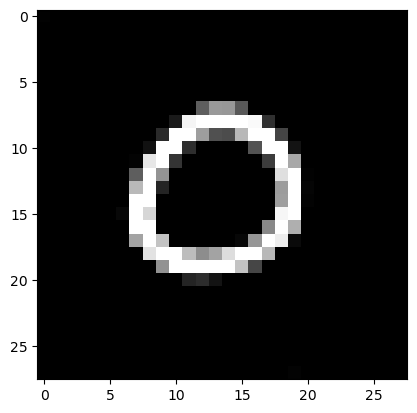

In [36]:
test_prediction(0,data["w1"],data["b1"],data["w2"],data["b2"],data["w3"],data["b3"])

In [37]:
tedf=tedf*255

In [38]:
np.unique(tedf)

array([  0.,   2.,   3.,   5.,   7.,   8.,  10.,  12.,  14.,  15.,  17.,
        19.,  20.,  22.,  24.,  26.,  27.,  29.,  31.,  32.,  34.,  36.,
        37.,  39.,  41.,  42.,  44.,  46.,  48.,  49.,  51.,  53.,  54.,
        56.,  58.,  60.,  61.,  63.,  65.,  66.,  68.,  70.,  71.,  73.,
        75.,  76.,  78.,  80.,  82.,  83.,  85.,  87.,  88.,  90.,  92.,
        94.,  95.,  97.,  99., 100., 102., 104., 105., 107., 109., 112.,
       114., 116., 117., 119., 121., 122., 124., 126., 128., 129., 133.,
       134., 136., 138., 139., 141., 144., 146., 148., 150., 151., 153.,
       155., 156., 158., 160., 162., 163., 165., 167., 168., 170., 172.,
       173., 175., 177., 178., 180., 182., 184., 185., 187., 189., 192.,
       194., 196., 197., 199., 201., 202., 204., 206., 207., 209., 211.,
       212., 214., 216., 219., 221., 223., 224., 226., 228., 230., 231.,
       233., 235., 236., 238., 240., 241., 243., 245., 246., 248., 250.,
       252., 253., 255.])

In [39]:
def plot_training_validation_loss(train_losses, val_losses, step):
    """
    Plot training and validation cross-entropy loss over iterations.

    Args:
        train_losses (list): Training losses recorded during training.
        val_losses (list): Validation losses recorded during training.
        step (int): Interval of iterations at which losses were recorded.
    """
    iterations = [i * step for i in range(len(train_losses))]

    plt.figure(figsize=(8, 5))
    plt.plot(iterations, train_losses, label="Training Loss", color="blue")
    plt.plot(iterations, val_losses, label="Validation Loss", color="orange")
    plt.xlabel("Iterations")
    plt.ylabel("Cross-Entropy Loss")
    plt.title("Evolution of Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [40]:
# Example: 80% train, 20% validation
val_split = int(0.8 * x_train.shape[1])
x_train_part = x_train[:, :val_split]
y_train_part = y_train[:val_split]

x_val = x_train[:, val_split:]
y_val = y_train[val_split:]
train_losses = []
val_losses = []

In [41]:
def gradient_descent(x_train, y_train, x_val, y_val, iterations=1000, alpha=0.001, step=50):
    """
    Gradient descent with Adam optimizer, tracking training and validation loss.
    """
    w1, b1, w2, b2, w3, b3 = init_params()
    v, s = init_adam(w1, b1, w2, b2, w3, b3)

    train_losses = []
    val_losses = []

    for i in range(1, iterations + 1):
        # Forward + backward on training set
        z1, a1, z2, a2, z3, a3 = forward_prop(w1, b1, w2, b2, w3, b3, x_train)
        dw1, db1, dw2, db2, dw3, db3 = back_prop(z1, a1, z2, a2, z3, a3, w2, w3, x_train, y_train)
        w1, b1, w2, b2, w3, b3, v, s = update_params_adam(
            w1, b1, w2, b2, w3, b3,
            dw1, db1, dw2, db2, dw3, db3,
            v, s, i, alpha
        )

        # Record losses
        train_loss = compute_loss(a3, y_train)

        # Compute validation loss
        _, _, _, _, _, a3_val = forward_prop(w1, b1, w2, b2, w3, b3, x_val)
        val_loss = compute_loss(a3_val, y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print progress every 'step' iterations
        if i % step == 0:
            train_acc = get_accuracy(get_predictions(a3), y_train)
            val_acc = get_accuracy(get_predictions(a3_val), y_val)
            print(f"Iteration {i}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Plot training and validation loss
    plot_training_validation_loss(train_losses, val_losses, step=1)

    return w1, b1, w2, b2, w3, b3


[7 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
[7 4 3 ... 7 9 8] [7 4 3 ... 7 9 8]
Iteration 50: Train Loss=0.4648, Val Loss=0.4456, Train Acc=0.8898, Val Acc=0.8932
[7 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
[7 4 3 ... 7 9 8] [7 4 3 ... 7 9 8]
Iteration 100: Train Loss=0.2897, Val Loss=0.2786, Train Acc=0.9275, Val Acc=0.9304
[7 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
[7 4 3 ... 7 9 8] [7 4 3 ... 7 9 8]
Iteration 150: Train Loss=0.2326, Val Loss=0.2232, Train Acc=0.9399, Val Acc=0.9417
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
[7 4 3 ... 7 9 8] [7 4 3 ... 7 9 8]
Iteration 200: Train Loss=0.1992, Val Loss=0.1904, Train Acc=0.9489, Val Acc=0.9510
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
[7 4 3 ... 7 9 8] [7 4 3 ... 7 9 8]
Iteration 250: Train Loss=0.1756, Val Loss=0.1674, Train Acc=0.9551, Val Acc=0.9572
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
[7 4 3 ... 7 9 8] [7 4 3 ... 7 9 8]
Iteration 300: Train Loss=0.1576, Val Loss=0.1501, Train Acc=0.9594, Val Acc=0.9611
[9 6 9 ... 7 9 8] [9 6 9 ... 7 9 8]
[7 4 3 ... 7 9 8] [7 4 3 ... 

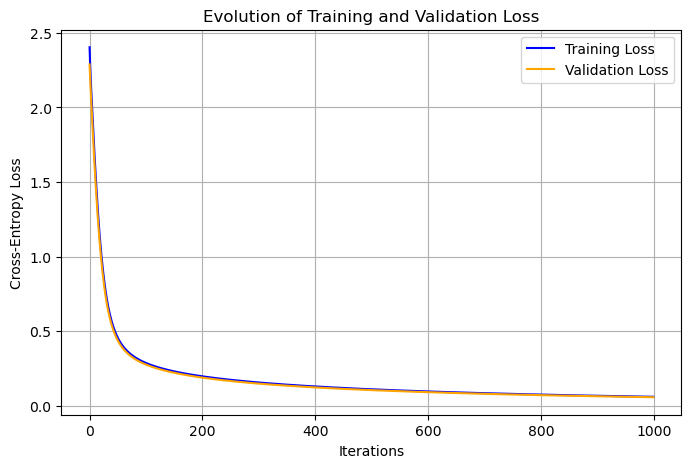

In [47]:
w1,b1,w2,b2,w3,b3=gradient_descent(x_train, y_train, x_val, y_val, iterations=1000, alpha=0.001, step=50)

In [42]:
def plot_class_errors_nn(x_test, y_test, w1, b1, w2, b2,w3,b3):
    """
    Plot percentage of incorrectly predicted labels per class for NN model.
    
    Args:
        x_test (ndarray): Test features, shape (784, m).
        y_test (ndarray): True labels, shape (m,).
        w1, b1, w2, b2: Trained neural network parameters.
    """
    # Get predictions using your NN
    y_pred = make_prediction(x_test, w1, b1, w2, b2,w3,b3)

    classes = np.arange(10)  # digit classes 0-9
    errors = []

    for c in classes:
        # mask for class c
        mask = (y_test == c)
        total = np.sum(mask)
        incorrect = np.sum(y_pred[mask] != y_test[mask])
        error_rate = (incorrect / total * 100) if total > 0 else 0
        errors.append(error_rate)

    errors = np.array(errors)
    overall_error = np.mean(errors)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(classes, errors, color="skyblue", edgecolor="black")
    plt.axhline(y=overall_error, color="red", linestyle="--", 
                label=f"Overall Error: {overall_error:.2f}%")
    plt.xticks(classes)
    plt.xlabel("Digit Class (0-9)")
    plt.ylabel("Error Percentage (%)")
    plt.title("Percentage of Incorrectly Predicted Labels")
    plt.legend()
    plt.show()

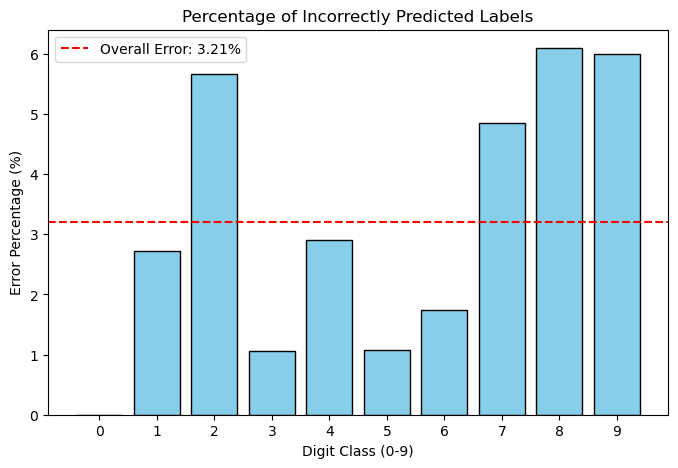

In [43]:
 plot_class_errors_nn(x_test, y_test, w1, b1, w2, b2,w3,b3)

In [44]:
def plot_class_errors_nn(x_test, y_test, w1, b1, w2, b2, w3, b3):
    """
    Plot percentage of incorrectly predicted labels per class for 3-layer NN model.
    
    Args:
        x_test (ndarray): Test features, shape (784, m).
        y_test (ndarray): True labels, shape (m,).
        w1, b1, w2, b2, w3, b3: Trained neural network parameters.
    """
    # Get predictions using 3-layer NN
    y_pred = make_prediction(x_test, w1, b1, w2, b2, w3, b3)

    classes = np.arange(10)  # digit classes 0-9
    errors = []

    for c in classes:
        # mask for class c
        mask = (y_test == c)
        total = np.sum(mask)
        incorrect = np.sum(y_pred[mask] != y_test[mask])
        error_rate = (incorrect / total * 100) if total > 0 else 0
        errors.append(error_rate)

    errors = np.array(errors)

    # ✅ True overall error (not mean of class errors)
    overall_error = np.mean(y_pred != y_test) * 100

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(classes, errors, color="skyblue", edgecolor="black")
    plt.axhline(y=overall_error, color="red", linestyle="--", 
                label=f"Overall Error: {overall_error:.2f}%")
    plt.xticks(classes)
    plt.xlabel("Digit Class (0-9)")
    plt.ylabel("Error Percentage (%)")
    plt.title("Percentage of Incorrectly Predicted Labels")
    plt.legend()
    plt.show()


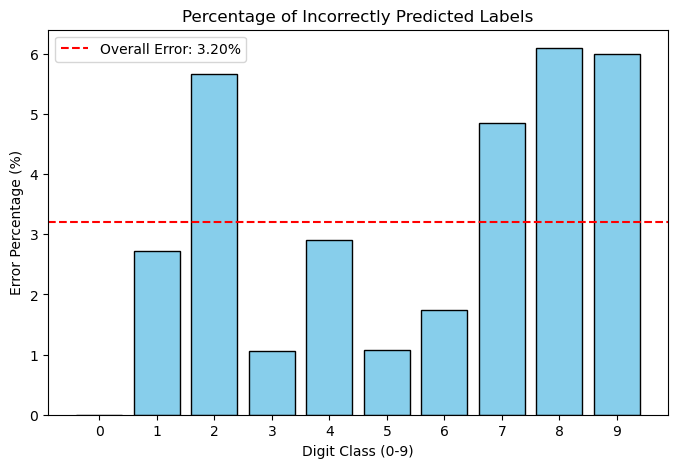

In [45]:
plot_class_errors_nn(x_test, y_test,data["w1"],data["b1"],data["w2"],data["b2"],data["w3"],data["b3"])